In [1]:
import os, json, sys, time, random
import numpy as np
import torch
from  easydict import EasyDict
from math import floor
from easydict import EasyDict

from steves_utils.vanilla_train_eval_test_jig import  Vanilla_Train_Eval_Test_Jig

from steves_utils.torch_utils import get_dataset_metrics, independent_accuracy_assesment
from steves_models.configurable_vanilla import Configurable_Vanilla
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.lazy_map import Lazy_Map
from steves_utils.sequence_aggregator import Sequence_Aggregator

from steves_utils.stratified_dataset.traditional_accessor import Traditional_Accessor_Factory

from steves_utils.cnn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.torch_utils import (
    confusion_by_domain_over_dataloader,
    independent_accuracy_assesment
)

from steves_utils.utils_v2 import (
    per_domain_accuracy_from_confusion,
    get_datasets_base_path
)

# from steves_utils.ptn_do_report import TBD

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "dataset_seed",
    "seed",
    "labels",
    "domains_target",
    "domains_source",
    "num_examples_per_domain_per_label_source",
    "num_examples_per_domain_per_label_target",
    "batch_size",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "normalize_source",
    "normalize_target",
    "x_net",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "pickle_name_source",
    "pickle_name_target",
    "torch_default_dtype",
}

In [3]:
from steves_utils.ORACLE.utils_v2 import (
    ALL_SERIAL_NUMBERS,
    ALL_DISTANCES_FEET_NARROWED,
)

standalone_parameters = {}
standalone_parameters["experiment_name"] = "MANUAL CORES CNN"
standalone_parameters["lr"] = 0.0001
standalone_parameters["device"] = "cuda"

standalone_parameters["dataset_seed"] = 1337
standalone_parameters["seed"] = 1337
standalone_parameters["labels"] = ALL_SERIAL_NUMBERS

standalone_parameters["domains_source"] = [8,32,50]
standalone_parameters["domains_target"] = [14,20,26,38,44,]

standalone_parameters["num_examples_per_domain_per_label_source"]=-1
standalone_parameters["num_examples_per_domain_per_label_target"]=-1

standalone_parameters["pickle_name_source"] = "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"
standalone_parameters["pickle_name_target"] = "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"

standalone_parameters["torch_default_dtype"] = "torch.float32" 

standalone_parameters["batch_size"]=128

standalone_parameters["n_epoch"] = 3

standalone_parameters["patience"] = 10

standalone_parameters["criteria_for_best"] = "target_accuracy"
standalone_parameters["normalize_source"] = False
standalone_parameters["normalize_target"] = False

standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": len(standalone_parameters["labels"])}},
]

standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"

In [4]:
# Parameters
parameters = {
    "experiment_name": "cnn_1:cores",
    "device": "cuda",
    "lr": 0.0001,
    "labels": [
        "1-10.",
        "1-11.",
        "1-15.",
        "1-16.",
        "1-17.",
        "1-18.",
        "1-19.",
        "10-4.",
        "10-7.",
        "11-1.",
        "11-14.",
        "11-17.",
        "11-20.",
        "11-7.",
        "13-20.",
        "13-8.",
        "14-10.",
        "14-11.",
        "14-14.",
        "14-7.",
        "15-1.",
        "15-20.",
        "16-1.",
        "16-16.",
        "17-10.",
        "17-11.",
        "17-2.",
        "19-1.",
        "19-16.",
        "19-19.",
        "19-20.",
        "19-3.",
        "2-10.",
        "2-11.",
        "2-17.",
        "2-18.",
        "2-20.",
        "2-3.",
        "2-4.",
        "2-5.",
        "2-6.",
        "2-7.",
        "2-8.",
        "3-13.",
        "3-18.",
        "3-3.",
        "4-1.",
        "4-10.",
        "4-11.",
        "4-19.",
        "5-5.",
        "6-15.",
        "7-10.",
        "7-14.",
        "8-18.",
        "8-20.",
        "8-3.",
        "8-8.",
    ],
    "batch_size": 128,
    "domains_source": [1, 5],
    "domains_target": [2, 3, 4],
    "normalize_source": False,
    "normalize_target": False,
    "num_examples_per_domain_per_label_source": -1,
    "num_examples_per_domain_per_label_target": -1,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_accuracy",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 58}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "pickle_name_source": "cores.stratified_ds.2022A.pkl",
    "pickle_name_target": "cores.stratified_ds.2022A.pkl",
    "dataset_seed": 420,
    "seed": 420,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")



In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
def wrap_in_dataloader(p, ds):
    return torch.utils.data.DataLoader(
        ds,
        batch_size=p.batch_size,
        shuffle=True,
        num_workers=1,
        persistent_workers=True,
        prefetch_factor=50,
        pin_memory=True
    )

taf_source = Traditional_Accessor_Factory(
    labels=p.labels,
    domains=p.domains_source,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_source,
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name_source),
    seed=p.dataset_seed
)
train_original_source, val_original_source, test_original_source = \
    taf_source.get_train(), taf_source.get_val(), taf_source.get_test()


taf_target = Traditional_Accessor_Factory(
    labels=p.labels,
    domains=p.domains_target,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_source,
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name_target),
    seed=p.dataset_seed
)
train_original_target, val_original_target, test_original_target = \
    taf_target.get_train(), taf_target.get_val(), taf_target.get_test()


# For CNN We only use X and Y. And we only train on the source.
# Properly form the data using a transform lambda and Lazy_Map. Finally wrap them in a dataloader

transform_lambda = lambda ex: ex[:2] # Strip the tuple to just (x,y)


train_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(train_original_source, transform_lambda)
)
val_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(val_original_source, transform_lambda)
)
test_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(test_original_source, transform_lambda)
)

train_processed_target = wrap_in_dataloader(
    p,
    Lazy_Map(train_original_target, transform_lambda)
)
val_processed_target = wrap_in_dataloader(
    p,
    Lazy_Map(val_original_target, transform_lambda)
)
test_processed_target  = wrap_in_dataloader(
    p,
    Lazy_Map(test_original_target, transform_lambda)
)



datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [11]:
ep = next(iter(test_processed_target))
ep[0].dtype

torch.float32

In [12]:
model = Configurable_Vanilla(
    x_net=x_net,
    label_loss_object=torch.nn.NLLLoss(),
    learning_rate=p.lr
)

In [13]:
jig = Vanilla_Train_Eval_Test_Jig(
    model=model,
    path_to_best_model=p.BEST_MODEL_PATH,
    device=p.device,
    label_loss_object=torch.nn.NLLLoss(),
)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    patience=p.patience,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    criteria_for_best=p.criteria_for_best
)

epoch: 1, [batch: 1 / 568], examples_per_second: 719.2424, train_label_loss: 4.0069, 


epoch: 1, [batch: 57 / 568], examples_per_second: 10692.2283, train_label_loss: 2.8223, 


epoch: 1, [batch: 114 / 568], examples_per_second: 10662.8457, train_label_loss: 2.0938, 


epoch: 1, [batch: 171 / 568], examples_per_second: 10780.7873, train_label_loss: 1.4254, 


epoch: 1, [batch: 227 / 568], examples_per_second: 10690.3045, train_label_loss: 0.9476, 


epoch: 1, [batch: 284 / 568], examples_per_second: 10702.6216, train_label_loss: 0.7217, 


epoch: 1, [batch: 341 / 568], examples_per_second: 10790.9223, train_label_loss: 0.4187, 


epoch: 1, [batch: 397 / 568], examples_per_second: 10789.2529, train_label_loss: 0.3686, 


epoch: 1, [batch: 454 / 568], examples_per_second: 10824.5540, train_label_loss: 0.2812, 


epoch: 1, [batch: 511 / 568], examples_per_second: 10598.5769, train_label_loss: 0.2257, 


epoch: 1, source_val_acc_label: 0.9609, source_val_label_loss: 0.2853, target_val_acc_label: 0.7922, target_val_label_loss: 0.8422, 


New best
epoch: 2, [batch: 1 / 568], examples_per_second: 100.0405, train_label_loss: 0.4494, 


epoch: 2, [batch: 57 / 568], examples_per_second: 10559.5353, train_label_loss: 0.3480, 


epoch: 2, [batch: 114 / 568], examples_per_second: 10747.2642, train_label_loss: 0.1638, 


epoch: 2, [batch: 171 / 568], examples_per_second: 10814.5659, train_label_loss: 0.2376, 


epoch: 2, [batch: 227 / 568], examples_per_second: 10855.1579, train_label_loss: 0.1316, 


epoch: 2, [batch: 284 / 568], examples_per_second: 10824.3319, train_label_loss: 0.0857, 


epoch: 2, [batch: 341 / 568], examples_per_second: 10792.4484, train_label_loss: 0.1212, 


epoch: 2, [batch: 397 / 568], examples_per_second: 10786.2685, train_label_loss: 0.0582, 


epoch: 2, [batch: 454 / 568], examples_per_second: 10753.5183, train_label_loss: 0.0734, 


epoch: 2, [batch: 511 / 568], examples_per_second: 10672.2799, train_label_loss: 0.0681, 


epoch: 2, source_val_acc_label: 0.9929, source_val_label_loss: 0.0648, target_val_acc_label: 0.8602, target_val_label_loss: 0.5835, 


New best
epoch: 3, [batch: 1 / 568], examples_per_second: 116.7895, train_label_loss: 0.0549, 


epoch: 3, [batch: 57 / 568], examples_per_second: 10704.1170, train_label_loss: 0.0824, 


epoch: 3, [batch: 114 / 568], examples_per_second: 10744.4078, train_label_loss: 0.0402, 


epoch: 3, [batch: 171 / 568], examples_per_second: 10710.3605, train_label_loss: 0.0422, 


epoch: 3, [batch: 227 / 568], examples_per_second: 10819.6943, train_label_loss: 0.0435, 


epoch: 3, [batch: 284 / 568], examples_per_second: 10853.8477, train_label_loss: 0.0274, 


epoch: 3, [batch: 341 / 568], examples_per_second: 10831.5386, train_label_loss: 0.0335, 


epoch: 3, [batch: 397 / 568], examples_per_second: 10787.5766, train_label_loss: 0.0351, 


epoch: 3, [batch: 454 / 568], examples_per_second: 10686.6548, train_label_loss: 0.0403, 


epoch: 3, [batch: 511 / 568], examples_per_second: 10831.6651, train_label_loss: 0.0238, 


epoch: 3, source_val_acc_label: 0.9957, source_val_label_loss: 0.0329, target_val_acc_label: 0.8700, target_val_label_loss: 0.4966, 


New best
epoch: 4, [batch: 1 / 568], examples_per_second: 118.1112, train_label_loss: 0.0262, 


epoch: 4, [batch: 57 / 568], examples_per_second: 10552.1081, train_label_loss: 0.0589, 


epoch: 4, [batch: 114 / 568], examples_per_second: 10771.0655, train_label_loss: 0.0449, 


epoch: 4, [batch: 171 / 568], examples_per_second: 10808.8324, train_label_loss: 0.0344, 


epoch: 4, [batch: 227 / 568], examples_per_second: 10758.5588, train_label_loss: 0.0336, 


epoch: 4, [batch: 284 / 568], examples_per_second: 10669.2734, train_label_loss: 0.0194, 


epoch: 4, [batch: 341 / 568], examples_per_second: 10734.1415, train_label_loss: 0.0209, 


epoch: 4, [batch: 397 / 568], examples_per_second: 10747.6938, train_label_loss: 0.0289, 


epoch: 4, [batch: 454 / 568], examples_per_second: 10750.7945, train_label_loss: 0.0162, 


epoch: 4, [batch: 511 / 568], examples_per_second: 10731.6119, train_label_loss: 0.0134, 


epoch: 4, source_val_acc_label: 0.9967, source_val_label_loss: 0.0243, target_val_acc_label: 0.8638, target_val_label_loss: 0.5328, 


epoch: 5, [batch: 1 / 568], examples_per_second: 122.3218, train_label_loss: 0.0312, 


epoch: 5, [batch: 57 / 568], examples_per_second: 10232.3634, train_label_loss: 0.0094, 


epoch: 5, [batch: 114 / 568], examples_per_second: 10725.7441, train_label_loss: 0.0114, 


epoch: 5, [batch: 171 / 568], examples_per_second: 10590.9803, train_label_loss: 0.0097, 


epoch: 5, [batch: 227 / 568], examples_per_second: 10765.0614, train_label_loss: 0.0107, 


epoch: 5, [batch: 284 / 568], examples_per_second: 10852.5043, train_label_loss: 0.0148, 


epoch: 5, [batch: 341 / 568], examples_per_second: 10655.7355, train_label_loss: 0.0183, 


epoch: 5, [batch: 397 / 568], examples_per_second: 10824.8638, train_label_loss: 0.0059, 


epoch: 5, [batch: 454 / 568], examples_per_second: 10773.1700, train_label_loss: 0.0120, 


epoch: 5, [batch: 511 / 568], examples_per_second: 10648.3161, train_label_loss: 0.0058, 


epoch: 5, source_val_acc_label: 0.9963, source_val_label_loss: 0.0185, target_val_acc_label: 0.8759, target_val_label_loss: 0.4716, 


New best
epoch: 6, [batch: 1 / 568], examples_per_second: 121.3393, train_label_loss: 0.0086, 


epoch: 6, [batch: 57 / 568], examples_per_second: 10696.5308, train_label_loss: 0.0366, 


epoch: 6, [batch: 114 / 568], examples_per_second: 10606.0263, train_label_loss: 0.0130, 


epoch: 6, [batch: 171 / 568], examples_per_second: 10802.9180, train_label_loss: 0.0099, 


epoch: 6, [batch: 227 / 568], examples_per_second: 10874.6800, train_label_loss: 0.0082, 


epoch: 6, [batch: 284 / 568], examples_per_second: 10684.9831, train_label_loss: 0.0099, 


epoch: 6, [batch: 341 / 568], examples_per_second: 10760.2034, train_label_loss: 0.0047, 


epoch: 6, [batch: 397 / 568], examples_per_second: 10622.3741, train_label_loss: 0.0078, 


epoch: 6, [batch: 454 / 568], examples_per_second: 10740.6404, train_label_loss: 0.0087, 


epoch: 6, [batch: 511 / 568], examples_per_second: 10730.9495, train_label_loss: 0.0047, 


epoch: 6, source_val_acc_label: 0.9963, source_val_label_loss: 0.0209, target_val_acc_label: 0.8588, target_val_label_loss: 0.5890, 


epoch: 7, [batch: 1 / 568], examples_per_second: 121.9353, train_label_loss: 0.0048, 


epoch: 7, [batch: 57 / 568], examples_per_second: 10711.3552, train_label_loss: 0.0053, 


epoch: 7, [batch: 114 / 568], examples_per_second: 10802.2545, train_label_loss: 0.0041, 


epoch: 7, [batch: 171 / 568], examples_per_second: 10643.2868, train_label_loss: 0.0055, 


epoch: 7, [batch: 227 / 568], examples_per_second: 10743.3194, train_label_loss: 0.0062, 


epoch: 7, [batch: 284 / 568], examples_per_second: 10798.9648, train_label_loss: 0.0046, 


epoch: 7, [batch: 341 / 568], examples_per_second: 10778.3685, train_label_loss: 0.0052, 


epoch: 7, [batch: 397 / 568], examples_per_second: 10726.2132, train_label_loss: 0.0066, 


epoch: 7, [batch: 454 / 568], examples_per_second: 10633.4973, train_label_loss: 0.0030, 


epoch: 7, [batch: 511 / 568], examples_per_second: 10736.6008, train_label_loss: 0.0035, 


epoch: 7, source_val_acc_label: 0.9863, source_val_label_loss: 0.0625, target_val_acc_label: 0.8426, target_val_label_loss: 0.7420, 


epoch: 8, [batch: 1 / 568], examples_per_second: 124.2075, train_label_loss: 0.0097, 


epoch: 8, [batch: 57 / 568], examples_per_second: 10578.8786, train_label_loss: 0.0169, 


epoch: 8, [batch: 114 / 568], examples_per_second: 10756.3759, train_label_loss: 0.0102, 


epoch: 8, [batch: 171 / 568], examples_per_second: 10819.7432, train_label_loss: 0.0075, 


epoch: 8, [batch: 227 / 568], examples_per_second: 10851.0912, train_label_loss: 0.0057, 


epoch: 8, [batch: 284 / 568], examples_per_second: 10766.2643, train_label_loss: 0.0048, 


epoch: 8, [batch: 341 / 568], examples_per_second: 10676.1484, train_label_loss: 0.0044, 


epoch: 8, [batch: 397 / 568], examples_per_second: 10824.7001, train_label_loss: 0.0080, 


epoch: 8, [batch: 454 / 568], examples_per_second: 10725.7817, train_label_loss: 0.0026, 


epoch: 8, [batch: 511 / 568], examples_per_second: 10745.3057, train_label_loss: 0.0024, 


epoch: 8, source_val_acc_label: 0.9158, source_val_label_loss: 0.3024, target_val_acc_label: 0.7527, target_val_label_loss: 1.2034, 


epoch: 9, [batch: 1 / 568], examples_per_second: 126.1832, train_label_loss: 0.2034, 


epoch: 9, [batch: 57 / 568], examples_per_second: 10581.6712, train_label_loss: 0.0649, 


epoch: 9, [batch: 114 / 568], examples_per_second: 10890.8919, train_label_loss: 0.0379, 


epoch: 9, [batch: 171 / 568], examples_per_second: 10636.6906, train_label_loss: 0.0165, 


epoch: 9, [batch: 227 / 568], examples_per_second: 10750.0918, train_label_loss: 0.0166, 


epoch: 9, [batch: 284 / 568], examples_per_second: 10856.7241, train_label_loss: 0.0104, 


epoch: 9, [batch: 341 / 568], examples_per_second: 10802.3231, train_label_loss: 0.0096, 


epoch: 9, [batch: 397 / 568], examples_per_second: 10697.7677, train_label_loss: 0.0127, 


epoch: 9, [batch: 454 / 568], examples_per_second: 10813.4119, train_label_loss: 0.0088, 


epoch: 9, [batch: 511 / 568], examples_per_second: 10833.9660, train_label_loss: 0.0057, 


epoch: 9, source_val_acc_label: 0.9968, source_val_label_loss: 0.0175, target_val_acc_label: 0.8815, target_val_label_loss: 0.5068, 


New best
epoch: 10, [batch: 1 / 568], examples_per_second: 121.1966, train_label_loss: 0.0074, 


epoch: 10, [batch: 57 / 568], examples_per_second: 10706.0190, train_label_loss: 0.0067, 


epoch: 10, [batch: 114 / 568], examples_per_second: 10624.6552, train_label_loss: 0.0039, 


epoch: 10, [batch: 171 / 568], examples_per_second: 10836.1489, train_label_loss: 0.0024, 


epoch: 10, [batch: 227 / 568], examples_per_second: 10724.2963, train_label_loss: 0.0019, 


epoch: 10, [batch: 284 / 568], examples_per_second: 10696.5537, train_label_loss: 0.0068, 


epoch: 10, [batch: 341 / 568], examples_per_second: 10819.4142, train_label_loss: 0.0026, 


epoch: 10, [batch: 397 / 568], examples_per_second: 11954.4210, train_label_loss: 0.0021, 


epoch: 10, [batch: 454 / 568], examples_per_second: 11832.7488, train_label_loss: 0.0048, 


epoch: 10, [batch: 511 / 568], examples_per_second: 11751.5525, train_label_loss: 0.0070, 


epoch: 10, source_val_acc_label: 0.9925, source_val_label_loss: 0.0296, target_val_acc_label: 0.8611, target_val_label_loss: 0.6454, 


epoch: 11, [batch: 1 / 568], examples_per_second: 138.6647, train_label_loss: 0.0075, 


epoch: 11, [batch: 57 / 568], examples_per_second: 11587.7255, train_label_loss: 0.0482, 


epoch: 11, [batch: 114 / 568], examples_per_second: 11852.6485, train_label_loss: 0.0294, 


epoch: 11, [batch: 171 / 568], examples_per_second: 11836.9276, train_label_loss: 0.0122, 


epoch: 11, [batch: 227 / 568], examples_per_second: 11826.1552, train_label_loss: 0.0171, 


epoch: 11, [batch: 284 / 568], examples_per_second: 11788.6380, train_label_loss: 0.0158, 


epoch: 11, [batch: 341 / 568], examples_per_second: 11836.4286, train_label_loss: 0.0062, 


epoch: 11, [batch: 397 / 568], examples_per_second: 11865.2623, train_label_loss: 0.0137, 


epoch: 11, [batch: 454 / 568], examples_per_second: 11859.3824, train_label_loss: 0.0089, 


epoch: 11, [batch: 511 / 568], examples_per_second: 11832.6436, train_label_loss: 0.0079, 


epoch: 11, source_val_acc_label: 0.9961, source_val_label_loss: 0.0245, target_val_acc_label: 0.8526, target_val_label_loss: 0.5801, 


epoch: 12, [batch: 1 / 568], examples_per_second: 137.9878, train_label_loss: 0.0136, 


epoch: 12, [batch: 57 / 568], examples_per_second: 11712.7562, train_label_loss: 0.0171, 


epoch: 12, [batch: 114 / 568], examples_per_second: 11750.9613, train_label_loss: 0.0074, 


epoch: 12, [batch: 171 / 568], examples_per_second: 11856.9195, train_label_loss: 0.0122, 


epoch: 12, [batch: 227 / 568], examples_per_second: 12006.8751, train_label_loss: 0.0073, 


epoch: 12, [batch: 284 / 568], examples_per_second: 12391.4107, train_label_loss: 0.0070, 


epoch: 12, [batch: 341 / 568], examples_per_second: 11842.1587, train_label_loss: 0.0036, 


epoch: 12, [batch: 397 / 568], examples_per_second: 11827.7091, train_label_loss: 0.0078, 


epoch: 12, [batch: 454 / 568], examples_per_second: 11857.9946, train_label_loss: 0.0181, 


epoch: 12, [batch: 511 / 568], examples_per_second: 11707.2197, train_label_loss: 0.1087, 


epoch: 12, source_val_acc_label: 0.9411, source_val_label_loss: 0.2540, target_val_acc_label: 0.8056, target_val_label_loss: 0.9510, 


epoch: 13, [batch: 1 / 568], examples_per_second: 138.5832, train_label_loss: 0.0600, 


epoch: 13, [batch: 57 / 568], examples_per_second: 11597.6937, train_label_loss: 0.0633, 


epoch: 13, [batch: 114 / 568], examples_per_second: 11733.3085, train_label_loss: 0.0217, 


epoch: 13, [batch: 171 / 568], examples_per_second: 11817.3955, train_label_loss: 0.0072, 


epoch: 13, [batch: 227 / 568], examples_per_second: 11740.0018, train_label_loss: 0.0068, 


epoch: 13, [batch: 284 / 568], examples_per_second: 11760.8788, train_label_loss: 0.0195, 


epoch: 13, [batch: 341 / 568], examples_per_second: 11782.8733, train_label_loss: 0.0094, 


epoch: 13, [batch: 397 / 568], examples_per_second: 11811.3900, train_label_loss: 0.0051, 


epoch: 13, [batch: 454 / 568], examples_per_second: 11790.1686, train_label_loss: 0.0032, 


epoch: 13, [batch: 511 / 568], examples_per_second: 11757.2775, train_label_loss: 0.0052, 


epoch: 13, source_val_acc_label: 0.8669, source_val_label_loss: 0.9320, target_val_acc_label: 0.7572, target_val_label_loss: 1.7002, 


Patience (3) exhausted


In [14]:
total_experiment_time_secs = time.time() - start_time_secs

In [15]:
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = wrap_in_dataloader(p, Sequence_Aggregator((datasets.source.original.val, datasets.target.original.val)))

confusion = confusion_by_domain_over_dataloader(model, p.device, val_dl, forward_uses_domain=False)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

###################################
# Write out the results
###################################

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": p,
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "cnn"),
}

<AxesSubplot:title={'center':'Source Train Label Loss vs Source Val Label Loss'}, xlabel='Epoch'>

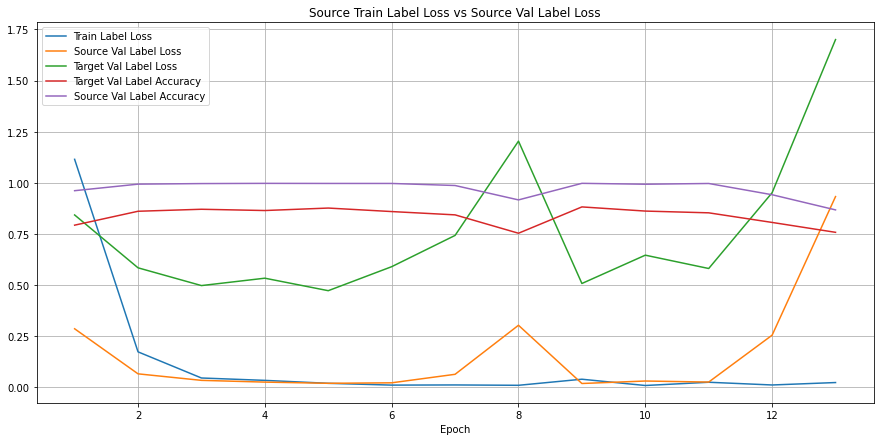

In [16]:
get_loss_curve(experiment)

<AxesSubplot:title={'center':'Results'}>

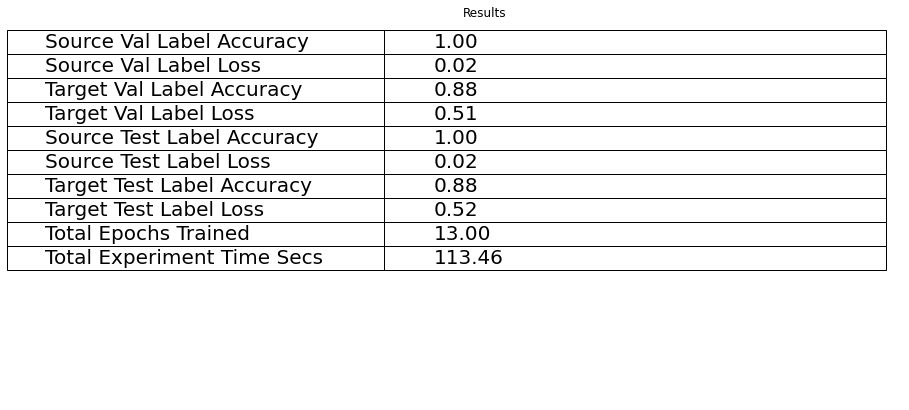

In [17]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Accuracy'}, xlabel='domain'>

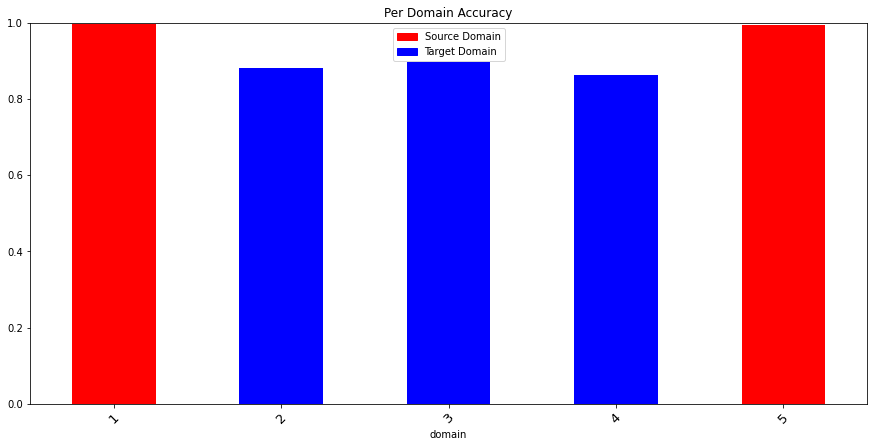

In [18]:
get_domain_accuracies(experiment)

In [19]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.9966815571155073 Target Test Label Accuracy: 0.8766382921226861
Source Val Label Accuracy: 0.9968405442001419 Target Val Label Accuracy: 0.881503416856492


In [20]:
json.dumps(experiment)

'{"experiment_name": "cnn_1:cores", "parameters": {"experiment_name": "cnn_1:cores", "device": "cuda", "lr": 0.0001, "labels": ["1-10.", "1-11.", "1-15.", "1-16.", "1-17.", "1-18.", "1-19.", "10-4.", "10-7.", "11-1.", "11-14.", "11-17.", "11-20.", "11-7.", "13-20.", "13-8.", "14-10.", "14-11.", "14-14.", "14-7.", "15-1.", "15-20.", "16-1.", "16-16.", "17-10.", "17-11.", "17-2.", "19-1.", "19-16.", "19-19.", "19-20.", "19-3.", "2-10.", "2-11.", "2-17.", "2-18.", "2-20.", "2-3.", "2-4.", "2-5.", "2-6.", "2-7.", "2-8.", "3-13.", "3-18.", "3-3.", "4-1.", "4-10.", "4-11.", "4-19.", "5-5.", "6-15.", "7-10.", "7-14.", "8-18.", "8-20.", "8-3.", "8-8."], "batch_size": 128, "domains_source": [1, 5], "domains_target": [2, 3, 4], "normalize_source": false, "normalize_target": false, "num_examples_per_domain_per_label_source": -1, "num_examples_per_domain_per_label_target": -1, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_best": "target_accuracy", "x_net": [{"